# Data Augmentation
## Augment training data for deep learning

## Step 1: load old data

In [59]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [60]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
l1 = set(y_train)
l2 = set(y_test)
l3 = set(y_valid)
lall = set.union(l1,l2,l3)
n_classes = len(lall)
if len(lall)>len(l1):
    print("Warning: training data does not contain some traffic signs")
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Step 2: visualize data distribution

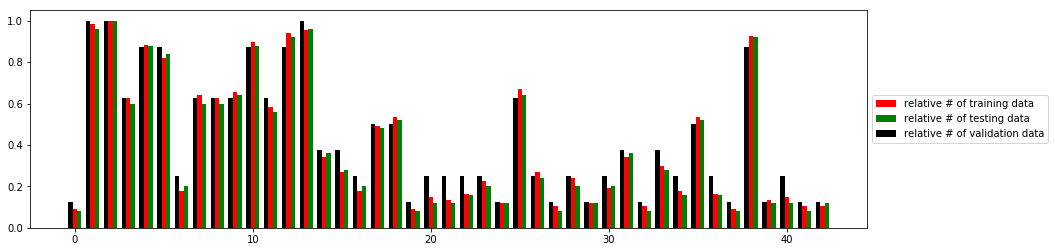

In [61]:
### get relative number of training, testing, and validation data
# get density map from data
def getHist(y):
    density = np.zeros((43,))
    for i in range(len(y)):
        density[y[i]] += 1
    return density

# plot prediction accuracy by signs and save model
fig = plt.figure(figsize=(15,4))
#fig, ax = plt.subplots()
width = 0.25
hist_train = getHist(y_train)
hist_test = getHist(y_test)
hist_valid = getHist(y_valid)
rects1 = plt.bar(np.arange(n_classes), hist_train/max(hist_train), width, color='r')    
rects2 = plt.bar(np.arange(n_classes) + width, hist_test/max(hist_test), width, color='g')
rects3 = plt.bar(np.arange(n_classes) - width, hist_valid/max(hist_valid), width, color='k')
l1 = plt.legend((rects1[0], rects2[0], rects3[0]), ('relative # of training data', 'relative # of testing data', 'relative # of validation data'), loc='center left', bbox_to_anchor=(1, 0.5))

## Step 3: generate data

In [62]:
### Augment data set (using rotation, shift, change contrast)
from PIL import Image
# shuffle datasets
from sklearn.utils import shuffle
import random
# rotate original image by degree
def Rotation(img, angle):
    img2 = Image.fromarray(img)
    img3 = img2.rotate(angle)
    imgout = np.array(img3)
    return imgout

# shift original image by dx, by
def Shift(img, dx, dy):
    imgout = np.zeros(img.shape)
    if dx>0 and dy>0:
        imgout[dx:, dy:, :] = img[:-dx, :-dy, :]
    if dx>0 and dy<0:
        imgout[dx:, :dy, :] = img[:-dx, -dy:, :]
    if dx<0 and dy>0:
        imgout[:dx, :-dy, :] = img[-dx:, :-dy, :]
    if dx<0 and dy<0:
        imgout[:dx, :dy, :] = img[-dx:, -dy:, :]
    return imgout.astype('uint8')

# change contrast of image
def Change_contrast(img, level):
    factor = (259.0 * (level + 255)) / (255.0 * (259 - level))
    img_new = 128.0 + factor*(img-128.0)
    imgout = np.maximum(0, np.minimum(255, img_new))
    return imgout.astype('uint8')

def genRandNew(img):
    flag = np.random.randint(0,3,(1,))
    if flag==0:
        numbers = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
        dx = random.choice(numbers)
        dy = random.choice(numbers)
        imgnew = Shift(img, dx, dy)
    elif flag==1:
        degree = np.random.randint(-60, 60, (1,))
        imgnew = Rotation(img, degree)
    elif flag==2:
        level = np.random.randint(-80,80,(1,))
        imgnew = Change_contrast(img, level)
    return imgnew.reshape(1,img.shape[0],img.shape[1],img.shape[2])

# augment the training dataset, if data for some sign is not sufficient
def Augment(x, y):
    # sort x and y by label
    yind = np.argsort(y)
    y = y[yind]
    x = x[yind]
    hist_y = getHist(y)
    # use the average of data point as targeted number of data points
    N = 1200#int(np.mean(hist_y)*0.3)
    for i in range(len(hist_y)):
        # augment if data amount for this sign is below average
        if (hist_train[i]<N):
            Nadd = N - hist_train[i]
            count = 0
            while count<Nadd:
                kadd = count%int(hist_train[i])
                if i>0:
                    kadd += int(sum(hist_train[:i]))
                imgnew = genRandNew(x[kadd])
                x= np.concatenate((x, imgnew), axis=0)
                y = np.append(y, y[kadd])
                count += 1
        if i%10 == 1:
            print("Finished augmenting class ", i, flush=True)
    # shuffle when additional data generated
    x, y = shuffle(x, y)
    return x, y

X_train, y_train = Augment(X_train, y_train)

Finished augmenting class  1
Finished augmenting class  11
Finished augmenting class  21
Finished augmenting class  31
Finished augmenting class  41


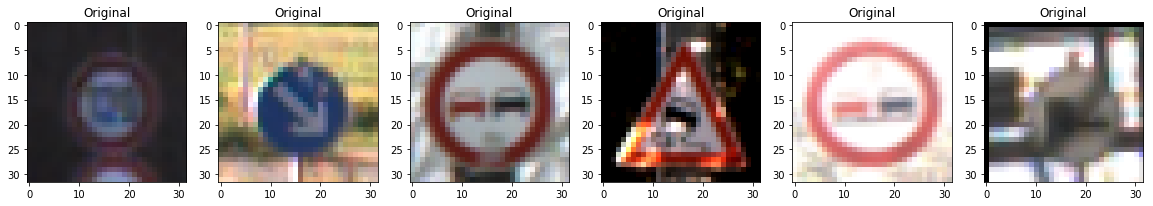

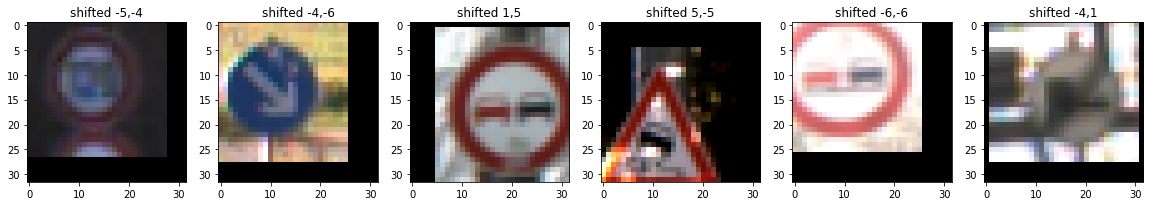

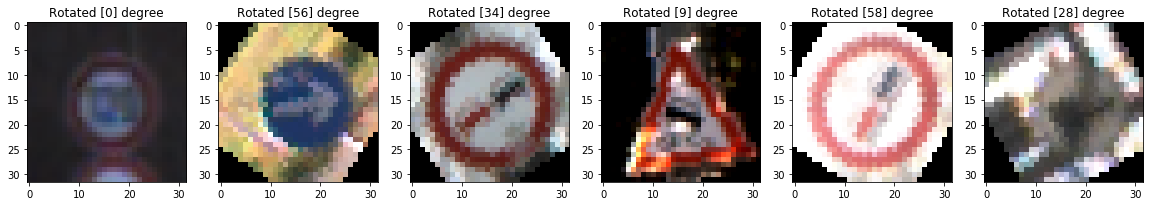

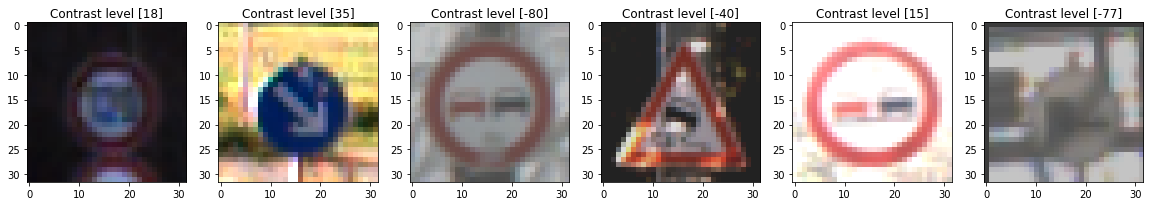

In [63]:
### plot img before and after augmentation
plt.figure(figsize=(20,20))
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    #plt.imshow(img,cmap='gray')
    plt.imshow(X_train[i])
    ax.set_title("Original")

# plot shifted figure
plt.figure(figsize=(20,20))
plt.title("Original figure")
numbers = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    dx = random.choice(numbers)
    dy = random.choice(numbers)
    ax.set_title("shifted %s,%s" %(dx,dy))
    img = Shift(X_train[i], dx, dy)
    #plt.imshow(img,cmap='gray')
    plt.imshow(img)    


# plot rotated figure
plt.figure(figsize=(20,20))
plt.title("Rotated figure")
#fig.suptitle("here is the title")
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    degree = np.random.randint(-60, 60, (1,))
    ax.set_title("Rotated %s degree" %degree)
    img = Rotation(X_train[i], degree)
    #plt.imshow(img,cmap='gray')
    plt.imshow(img)


# plot contrast figure
fig2 = plt.figure(figsize=(20,20))
plt.title("Shifted figure")
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    level = np.random.randint(-80,80,(1,))
    ax.set_title("Contrast level %s" %level)
    img = Change_contrast(X_train[i], level)
    #plt.imshow(img,cmap='gray')
    plt.imshow(img)

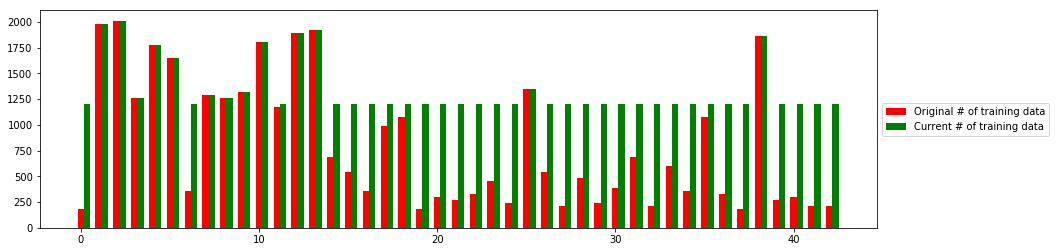

In [64]:
# Visualize training data distribution after augmentation
# plot prediction accuracy by signs and save model
fig = plt.figure(figsize=(15,4))
#fig, ax = plt.subplots()
width = 0.35
hist_train_new = getHist(y_train)
rects1 = plt.bar(np.arange(n_classes), hist_train, width, color='r')    
rects2 = plt.bar(np.arange(n_classes)+width, hist_train_new, width, color='g')    
l1 = plt.legend((rects1[0], rects2[0]), ('Original # of training data', 'Current # of training data'), loc='center left', bbox_to_anchor=(1, 0.5))

## Step 4: save data

In [65]:
train['features'] = X_train
train['labels'] = y_train
pickle.dump(train, open( "train_augmented.p", "wb" ) )